<a href="https://colab.research.google.com/github/hazrakeruboO/DS-Colabs/blob/main/pothole_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting up the environment

In [ ]:
# Connecting to drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Importing needed libraries for preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import cv2

%matplotlib inline

# Connecting to the specific director
os.chdir("/content/gdrive/Shared drives/group3_assignment")

In [ ]:
# Filtering warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# # Connecting to the TPU
# import tensorflow as tf

# #Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# #Connect to the TPU handle and initialise it
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
# Loading the train ids labels
train = pd.read_csv("data/train_ids_labels.csv")

In [ ]:
# Previewing training ids and labels
train.head()

,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0
2,tYKqoStvHsryFhS,1
3,eSpjlsZIwOMLmUS,1
4,uzxhIXjNENLyHwZ,1


In [ ]:
# Loading test data
test_file = pd.read_csv("data/test_ids_only.csv")

In [ ]:
# Previewing test ids
test_file.head()

,Image_ID
0,nRhHxqLhDlJsiXc
1,gbSntVovxgHQrmO
2,nqOobGmvgEOiPms
3,oIkPTooLcIbZKlF
4,eSKxsTTJDQzkjgD


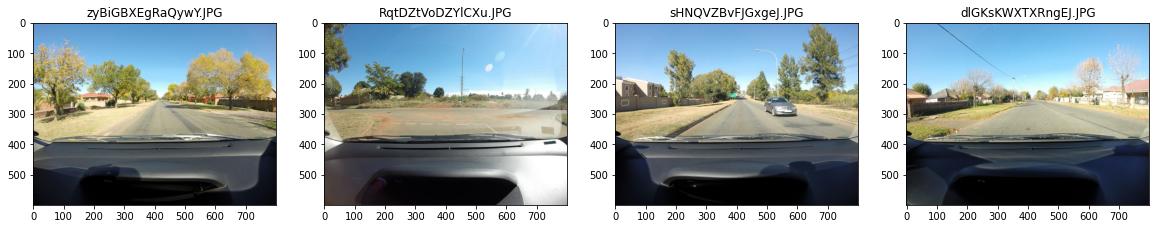

In [ ]:
# Previewing the images
plt.figure(figsize=(20,20))

# Getting the image folder
img_folder=r'data/all_data'

# Getting 4 images
for i in range(4):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,4,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

### Data Preprocessing

In [ ]:
# Creating a dictionary of image ids and labels
train.set_index('Image_ID',inplace=True)
labels = train.to_dict()['Label']

In [ ]:
#Number of images in train
len(labels)

4026

In [ ]:
# Previewing the keys
labels.keys()

dict_keys(['cVOfkSdqnWXUerr', 'EhnvIDPXFFjUhkR', 'tYKqoStvHsryFhS', 'eSpjlsZIwOMLmUS', 'uzxhIXjNENLyHwZ', 'hezYtxLhHStWATz', 'LcZuJysTXaSNBDe', 'RiWvALRpGwyReTK', 'kYQZTGpDvwXUZlu', 'VxXuRhwhHDvGWty', 'PVseTpBvTnqLDmk', 'FYshteAhtFDNsRp', 'gXTcncVAclMwbgO', 'EgbUBlfMujzEgNp', 'YlkqqPNsItojlbd', 'QSCIuzoPpaNAIJG', 'XcAfqmUulhlZSxb', 'dnWYyhuFKHvYLUP', 'ZbLhYIeGqrbjDsV', 'IRBwPwewbNqtmXJ', 'TtGADjTPcKRlGVx', 'aKiTqUaIwbfJgbj', 'GujejjcyPKhQeHr', 'bvrTzHpEopyOIqF', 'oUhcmNwKUPIlqPq', 'byLICfGenNZXXns', 'gmxqKOIXyTandEv', 'ZUmMzvEtCiEsZSv', 'qsaQkuDGROkiVzQ', 'PjtQkPLPyHGKImi', 'WlPSfKzgxDLiGzH', 'tIvhHpWkeAssHiK', 'bGXMaKypDRQEsiy', 'DpXXLZgIJdMPcdB', 'wTqibnxvEssJOul', 'qTgzOwHzsKxgNJQ', 'aGNsMQHylHTvxyU', 'VTmBKTBZgiYbbpY', 'mcLcRsNmKRDmzgq', 'toaFVqgiOilTeED', 'zaPmCwWjVxCZCwE', 'aRNCQqxJnicZYUM', 'szExoYRfsBmIPbw', 'uOwqleRPxcNRKBT', 'LlzeQXsYnhgAYRG', 'meGlerzXUnGHfuY', 'iTtyVAPfaMmSvkp', 'pxwMhqOlAmXpePO', 'noijddTUHckCVzl', 'ttHBDKFmtyHMxYR', 'vQoJhivnDNLOQEF', 'EhxBXNpIbHGhcKw', '

In [ ]:
# Turning the images to matrices(arrays of arrays)
img_size = 224 # Arbitrary choice, bigger size would contain more computations

def get_data(data_dir):
  ''' Function to load images as matrices and mapping them to their 
  labels. Returns two arrays of images-labels and images respectively'''
  data = []  # Initializing the list to store train images
  test = []  # Initializing the list to store test images
  num = 0 # Initializing counter to see how many images have been loaded
  path = os.path.join(data_dir)
  
  # Goes through all the images in the image folder
  for img in os.listdir(path):
    # Getting only train images(have labels)
    num += 1
    print(num,end=',')
    if img[:-4] in labels.keys():
      try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to defined size
        data.append([resized_arr, labels[img[:-4]]])
      except Exception as e: # To handle any error while loading images
          print(e)
    else: #getting test images(no labels)
      try:
        img_arr2 = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        resized_arr2 = cv2.resize(img_arr2, (img_size, img_size)) # Reshaping
        test.append([resized_arr2])
      except Exception as e:
          print(e)
  return np.array(data),np.array(test)

In [ ]:
data, test = get_data(img_folder)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

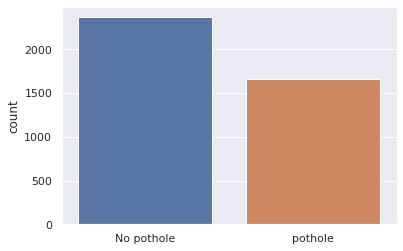

In [ ]:
# Visualising the counts of the classes
l = [] # List to store the different classes
for i in data:
    if i[1] == 0:
        l.append("No pothole")
    else:
        l.append("pothole")

# Plotting the different counts of classes
sns.set_theme(style="darkgrid")
ax = sns.countplot(l)

Text(0.5, 1.0, '0')

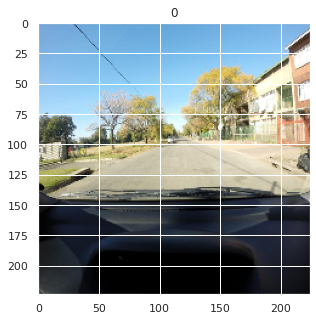

In [ ]:
# Viewing image with label 0 from the array 
plt.figure(figsize = (5,5))
plt.imshow(data[0][0])
plt.title(data[0][1])

Text(0.5, 1.0, '1')

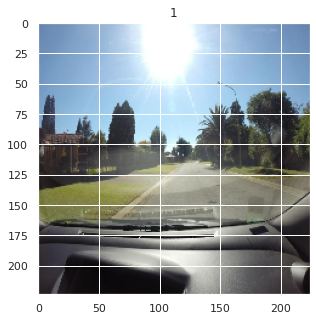

In [ ]:
# Viewing image with label 1 from the array 
plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(data[-1][1])

Text(0.5, 1.0, 'Test set image')

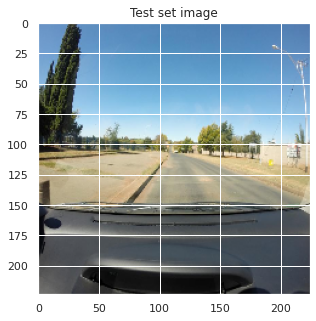

In [ ]:
# Viewing test set image from the array 
plt.figure(figsize = (5,5))
plt.imshow(test[-1][0])
plt.title("Test set image")

In [ ]:
# Checking out the shapes of processed images
print("Number of train images:",len(data))
print("Shape of image in data:",data[0][0].shape)
print("Number of test images:",len(test))
print("Shape of image in test:",test[0][0].shape)

Number of train images: 4026
Shape of image in data: (224, 224, 3)
Number of test images: 1650
Shape of image in test: (224, 224, 3)


In [ ]:
# Splitting data to train set and validation set
train, val = np.split(data,[int(0.7 * len(data))])

# Splitting features(X) and labels(y)
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

# Reshaping and converting back to arrays
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
x_val.shape

(1208, 224, 224, 3)

In [ ]:
# Importing libraries for modelling
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Sequential, Model

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Logistic regression

#### Preprocessing for logistic regression

In [ ]:
# Turning y_train and y_val to column vector
y_train = y_train[:, np.newaxis]
y_val = y_val[:, np.newaxis]

# Checking out the change
print("X train shape: " , x_train.shape)
print("Y train shape: " , y_train.shape)
print("X val shape: " , x_val.shape)
print("Y val shape: " , y_val.shape)

X train shape:  (2818, 224, 224, 3)
Y train shape:  (2818, 1)
X val shape:  (1208, 224, 224, 3)
Y val shape:  (1208, 1)


In [ ]:
# Flattening each image
x_train_flatten = x_train.reshape(x_train.shape[0],
                                  x_train.shape[1]*x_train.shape[2]*x_train.shape[3])
x_val_flatten = x_val.reshape(x_val.shape[0],
                              x_val.shape[1]*x_val.shape[2]*x_val.shape[3])

# Checking flattened data
print("X train flatten",x_train_flatten.shape)
print("X val flatten",x_val_flatten.shape)

# Checking out label vectors
print("y train: ",y_train.shape)
print("y test: ",y_val.shape)

X train flatten (2818, 150528)
X val flatten (1208, 150528)
y train:  (2818, 1)
y test:  (1208, 1)


In [ ]:
# Initializing logistic regression model
pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='sag'))

In [ ]:
pipe.fit(x_train_flatten,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='sag', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
predict_lr = pipe.predict(x_val_flatten)

In [ ]:
print(classification_report(y_val, predict_lr, target_names = ['No pothole (Class 0)','Pothole (Class 1)']))

                      precision    recall  f1-score   support

No pothole (Class 0)       0.76      0.98      0.85       427
   Pothole (Class 1)       0.99      0.83      0.90       781

            accuracy                           0.88      1208
           macro avg       0.87      0.90      0.88      1208
        weighted avg       0.90      0.88      0.88      1208



In [ ]:
# Test set to submit to Zindi
test = test.reshape(1650,224,224,3)

# Normalization
test = test/ 255

# Flattening
test_flatten = test.reshape(test.shape[0],test.shape[1]*test.shape[2]*test.shape[3])
test_flatten.shape

(1650, 150528)

In [ ]:
test_file['Label'] = pipe.predict(test_flatten)
test_file.to_csv('submission.csv',index=False)

In [ ]:
from sklearn import svm

In [ ]:
model3 = svm.SVC()

In [ ]:
model3.fit(x_train_flatten,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
preds = model3.predict(x_val_flatten)

In [ ]:
print(classification_report(y_val, preds, target_names = ['No pothole (Class 0)','Pothole (Class 1)']))

                      precision    recall  f1-score   support

No pothole (Class 0)       0.65      1.00      0.79       427
   Pothole (Class 1)       1.00      0.70      0.83       781

            accuracy                           0.81      1208
           macro avg       0.82      0.85      0.81      1208
        weighted avg       0.87      0.81      0.81      1208



# Deep learning:CNN

In [ ]:
# Building the model
model = Sequential()

# First Convolutional layer and maxpool layer
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

# Second Convolutional layer and maxpool layer
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

# Third Convolutional layer and maxpool layer
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

# Flattening layer
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

opt = Adam(lr=0.000001)
model.compile(optimizer = opt ,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [ ]:
x_train.shape

(2818, 224, 224, 3)

In [ ]:
history = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

Epoch 1/100
89/89 [==============================] - 35s 43ms/step - loss: 0.6471 - accuracy: 0.6574 - val_loss: 0.8588 - val_accuracy: 0.3535
Epoch 2/100
89/89 [==============================] - 3s 30ms/step - loss: 0.5985 - accuracy: 0.6860 - val_loss: 0.8059 - val_accuracy: 0.3535
Epoch 3/100
89/89 [==============================] - 3s 29ms/step - loss: 0.5845 - accuracy: 0.6869 - val_loss: 0.7711 - val_accuracy: 0.3816
Epoch 4/100
89/89 [==============================] - 3s 29ms/step - loss: 0.5505 - accuracy: 0.7143 - val_loss: 0.7228 - val_accuracy: 0.5017
Epoch 5/100
89/89 [==============================] - 3s 29ms/step - loss: 0.5392 - accuracy: 0.7397 - val_loss: 0.7146 - val_accuracy: 0.5546
Epoch 6/100
89/89 [==============================] - 3s 29ms/step - loss: 0.5268 - accuracy: 0.7489 - val_loss: 0.6696 - val_accuracy: 0.6374
Epoch 7/100
89/89 [==============================] - 3s 29ms/step - loss: 0.5099 - accuracy: 0.7836 - val_loss: 0.6622 - val_accuracy: 0.6573
Epoch

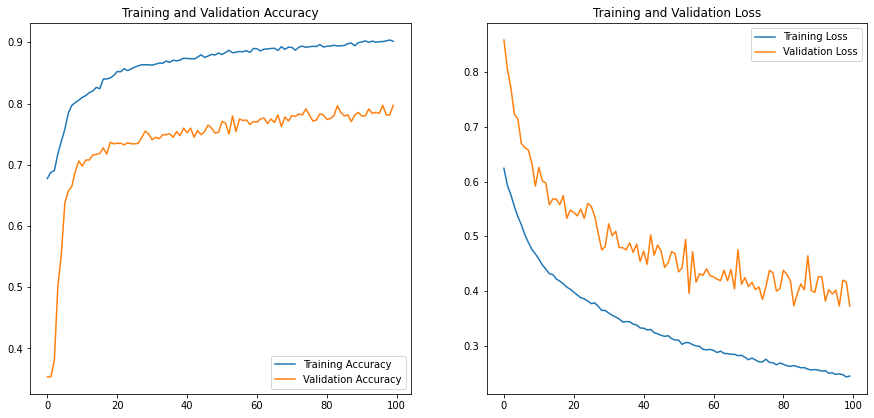

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['No pothole (Class 0)','Pothole (Class 1)']))

                      precision    recall  f1-score   support

No pothole (Class 0)       0.64      0.98      0.77       427
   Pothole (Class 1)       0.99      0.70      0.82       781

            accuracy                           0.80      1208
           macro avg       0.81      0.84      0.80      1208
        weighted avg       0.86      0.80      0.80      1208



In [ ]:
test_file['Label'] = model.predict_classes(test)
test_file.to_csv('submission2.csv',index=False)